In [1]:
import pandas as pd

from pandas_datareader import data as pdr

import yfinance as yf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy
import scipy.stats as st

# Create our portfolio of equities
tickers = ['^GSPC']
 
# Set the investment weightings (I arbitrarily picked for example)
weights = np.array([1])
 
# Set an initial investment level
initial_investment = 100000
 
# Download closing prices
data = pdr.get_data_yahoo(tickers, start="2010-01-01", end=datetime.date.today())['Adj Close']
 
#From the closing prices, calculate periodic returns

#Simple Return

#returns = data.pct_change().dropna()

returns = np.log(data/data.shift(1)).dropna()

returns

Symbols,^GSPC
Date,
2010-01-05,0.003111
2010-01-06,0.000545
2010-01-07,0.003993
2010-01-08,0.002878
2010-01-11,0.001745
...,...
2022-06-07,0.009478
2022-06-08,-0.010853
2022-06-09,-0.024086


In [2]:
r = returns.mean().dot(weights)

vol = np.sqrt(weights.T.dot(returns.cov()).dot(weights))

print('mean return: {: 4f}, volatility: {: 4f}'.format(r, vol))

mean return:  0.000382, volatility:  0.011074


In [3]:

#daily_returns = pd.Series((1e5*returns)@weights,index=returns.index)

daily_returns = pd.DataFrame(returns.dot(weights) * initial_investment)

#daily_returns.sort_values(inplace = True)


daily_returns['Quarter'] = pd.PeriodIndex(daily_returns.index, freq='Q')

daily_returns.rename(columns={ daily_returns.columns[0]: "Returns" }, inplace = True)


daily_returns = daily_returns[['Quarter', 'Returns']]

daily_returns

,Quarter,Returns
Date,,
2010-01-05,2010Q1,311.083197
2010-01-06,2010Q1,54.537189
2010-01-07,2010Q1,399.321835
2010-01-08,2010Q1,287.758308
2010-01-11,2010Q1,174.523163
...,...,...
2022-06-07,2022Q2,947.833153
2022-06-08,2022Q2,-1085.262304
2022-06-09,2022Q2,-2408.645767


In [4]:
        
dct = {}
for idx, v in enumerate(daily_returns['Quarter'].unique()):
    dct[f'{v}'] = daily_returns.loc[daily_returns['Quarter'] == v]
    
dct['2010Q1'].head(5)

,Quarter,Returns
Date,,
2010-01-05,2010Q1,311.083197
2010-01-06,2010Q1,54.537189
2010-01-07,2010Q1,399.321835
2010-01-08,2010Q1,287.758308
2010-01-11,2010Q1,174.523163


In [5]:
volatility = {}

for i in list(daily_returns['Quarter'].unique().strftime('%YQ%q')):
    volatility[f'{i}'] = (dct[i]['Returns'].std())
    

current_vol = volatility[sorted(volatility.keys())[-1]]

norm_vol = current_vol/(list(volatility.values()))

norm_vol = pd.DataFrame(norm_vol, index = daily_returns['Quarter'].unique(), columns = ['Normalisation'])

norm_vol.head(5)

,Normalisation
2010Q1,2.013886
2010Q2,1.151542
2010Q3,1.586927
2010Q4,2.433937
2011Q1,2.168351


In [6]:
daily_returns = daily_returns.merge(norm_vol, left_on='Quarter', right_index=True, how='left')



In [7]:
daily_returns['Normalised Return'] = daily_returns['Returns'] * daily_returns['Normalisation']

daily_returns.head(5)

,Quarter,Returns,Normalisation,Normalised Return
Date,,,,
2010-01-05,2010Q1,311.083197,2.013886,626.485949
2010-01-06,2010Q1,54.537189,2.013886,109.831655
2010-01-07,2010Q1,399.321835,2.013886,804.188467
2010-01-08,2010Q1,287.758308,2.013886,579.512292
2010-01-11,2010Q1,174.523163,2.013886,351.469673


In [8]:
standard_return = np.array(daily_returns['Returns'])
norm_return = np.array(daily_returns['Normalised Return'])

#list(norm_return)

In [9]:
def ES(c,x):
    Var=np.percentile(c,(1-x)*100)
    ES=c[c<=Var].mean()
    
    return [Var, abs(ES)]

ES(standard_return, 0.975)

ES(norm_return, 0.975)


ES_daily = ES(standard_return, 0.975)[1]
ES_norm_daily = ES(norm_return, 0.975)[1]

print(ES_daily, ES_norm_daily)



3560.7586686579325 4963.250560059316


In [10]:
num_days = 10

ES_nday = []

for i in range(1, num_days+1):
    ES_nday.append(np.round(ES_daily * np.sqrt(i),2))
    print(str(i) + ' day ES at 97.5% confidence level: ' + str(ES_nday[i-1]))

1 day ES at 97.5% confidence level: 3560.76
2 day ES at 97.5% confidence level: 5035.67
3 day ES at 97.5% confidence level: 6167.41
4 day ES at 97.5% confidence level: 7121.52
5 day ES at 97.5% confidence level: 7962.1
6 day ES at 97.5% confidence level: 8722.04
7 day ES at 97.5% confidence level: 9420.88
8 day ES at 97.5% confidence level: 10071.35
9 day ES at 97.5% confidence level: 10682.28
10 day ES at 97.5% confidence level: 11260.11


In [11]:
ES_norm_nday = []

for i in range(1, num_days+1):
    ES_norm_nday.append(np.round(ES_norm_daily * np.sqrt(i),2))
    print(str(i) + ' day historical volatility adjusted ES at 97.5% confidence level: ' + str(ES_norm_nday[i-1]))


1 day historical volatility adjusted ES at 97.5% confidence level: 4963.25
2 day historical volatility adjusted ES at 97.5% confidence level: 7019.1
3 day historical volatility adjusted ES at 97.5% confidence level: 8596.6
4 day historical volatility adjusted ES at 97.5% confidence level: 9926.5
5 day historical volatility adjusted ES at 97.5% confidence level: 11098.17
6 day historical volatility adjusted ES at 97.5% confidence level: 12157.43
7 day historical volatility adjusted ES at 97.5% confidence level: 13131.53
8 day historical volatility adjusted ES at 97.5% confidence level: 14038.19
9 day historical volatility adjusted ES at 97.5% confidence level: 14889.75
10 day historical volatility adjusted ES at 97.5% confidence level: 15695.18


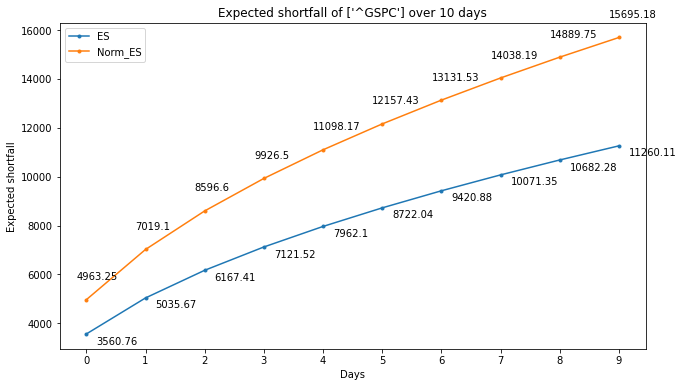

In [42]:
fig, ax = plt.subplots()

x = list(range(0,10))
#x = np.linspace(1,10,10)


ax.plot(ES_nday, marker='.', linestyle='-', label = 'ES')
ax.plot(ES_norm_nday, marker='.', linestyle='-', label = 'Norm_ES')
plt.title(f'Expected shortfall of {tickers} over 10 days')
plt.xticks(x)

ax.set_xlabel(f'Days')
ax.set_ylabel(f'Expected shortfall')

for a,b in zip(x, ES_nday):
    ax.annotate(str(b),xy=(a,b), xytext=(10,-10), textcoords='offset points')
    
for a,b in zip(x, ES_norm_nday):
    ax.annotate(str(b),xy=(a,b), xytext=(-10,20), textcoords='offset points')

    
    
ax.legend()
fig.set_size_inches(10.5, 6)